In [1]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for machine learning
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump,load
import shap

# Display setting for exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Check out if the environment is the correct Anaconda one
import sys
print('environment: ',sys.executable)

# Set up directory to be the github repository
# requires git
import os
import subprocess
os.getcwd()
output = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
path = output.decode('utf-8').strip()
print('working directory: ',path)
os.chdir(path)


environment:  c:\Users\ricca\Documents\Codice\Anaconda\envs\Thesis\python.exe
working directory:  C:/Users/ricca/Documents/Codice/Uni/Thesis-SEM-ML


In [3]:
from Source.DataPreparation.DataProcessor import DataProcessor
from Source.Classification.observed_variables_classification import GBoostClassification, LogisticRegressionClass

In [4]:
Results_XGB_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_LR_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_Random_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_Majority_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_XGB_Proba_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}


In [5]:
montecarloiter=10

for i in range(montecarloiter):
    print(f"Starting the iteration n.{i+1}")
    processorclass=DataProcessor()
    processorclass.read_df()
    processorclass.split_data(test_size=0.3)
    processorclass.save_data()
    try:
        processorclass.process_CFA()
    except Exception as e:
        print(f"Error during process_CFA for iteration n.{i+1}: {e}")
        continue    

    for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
        print(f"Starting the iteration n.{i+1} for dimension {dimension}")

        X_train,y_train,X_test,y_test = processorclass.train_test_data_for_WEtarget(target_variable=dimension,combineseldom=True)

         # Calculate random and majority classifier accuracy
        class_counts = np.bincount(y_test)
        class_probabilities = class_counts / len(y_test)
        random_accuracy = np.sum(class_probabilities**2)
        Results_Random_dict[dimension].append(random_accuracy)
        print(f"Accuracy of a random classifier for dimension {dimension}: {random_accuracy:.4f}")
        majority_class = np.argmax(class_counts)
        majority_accuracy = class_counts[majority_class] / len(y_test)
        Results_Majority_dict[dimension].append(majority_accuracy)
        print(f"Accuracy of a majority classifier for dimension {dimension}: {majority_accuracy:.4f}")


        # XGBClassifier
        Xgboost=GBoostClassification(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
        Xgboost.train(verbosity=0,n_iter=50)
        mxgbresults = Xgboost.get_results()
        Results_XGB_dict[dimension].append((mxgbresults['accuracy'],mxgbresults['precision'],mxgbresults['recall'],mxgbresults['train_accuracy'],mxgbresults['train_precision'],mxgbresults['train_recall']))
        Results_XGB_Proba_dict[dimension].append(Xgboost.get_probas())
        print(f"Iteration {i+1} XGBoost: accuracy: {mxgbresults['accuracy']}, precision: {mxgbresults['precision']}, recall: {mxgbresults['recall']}, train_accuracy:{mxgbresults['train_accuracy']}")

        # Logistic Regression
        LRcla= LogisticRegressionClass(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
        LRcla.median_imputation()
        LRcla.train(verbosity=0)
        LRresults = LRcla.get_results()
        Results_LR_dict[dimension].append((LRresults['accuracy'],LRresults['precision'],LRresults['recall'],LRresults['train_accuracy'],LRresults['train_precision'],LRresults['train_recall']))

        print(f"Iteration {i+1} Logistic: accuracy: {LRresults['accuracy']}, precision: {LRresults['precision']}, recall: {LRresults['recall']}, train_accuracy:{LRresults['train_accuracy']}")

        print(("-------------------------------------------------"))

Starting the iteration n.1
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the iteration n.1 for dimension eng_timeflies
Values of the classes 1 and 2 were combined.
Accuracy of a random classifier for dimension eng_timeflies: 0.3351
Accuracy of a majority classifier for dimension eng_timeflies: 0.4330
Starting the XGBClassifier training


The objective has been evaluated at this point before.


Iteration 1 XGBoost: accuracy: 0.4972067039106145, precision: 0.4879894374328321, recall: 0.4972067039106145, train_accuracy:0.5407673860911271
Starting the Logistic Regression
Iteration 1 Logistic: accuracy: 0.48324022346368717, precision: 0.4561443770011733, recall: 0.48324022346368717, train_accuracy:0.4856115107913669
-------------------------------------------------
Starting the iteration n.1 for dimension eng_enthusiastic
Values of the classes 1 and 2 were combined.
Accuracy of a random classifier for dimension eng_enthusiastic: 0.3065
Accuracy of a majority classifier for dimension eng_enthusiastic: 0.3939
Starting the XGBClassifier training
Iteration 1 XGBoost: accuracy: 0.5307262569832403, precision: 0.5371253336852897, recall: 0.5307262569832403, train_accuracy:0.6870503597122302
Starting the Logistic Regression
Iteration 1 Logistic: accuracy: 0.5307262569832403, precision: 0.5258517748125766, recall: 0.5307262569832403, train_accuracy:0.6031175059952039
---------------------

The objective has been evaluated at this point before.


Iteration 9 XGBoost: accuracy: 0.48324022346368717, precision: 0.4970940057104328, recall: 0.48324022346368717, train_accuracy:0.552757793764988
Starting the Logistic Regression
Iteration 9 Logistic: accuracy: 0.4581005586592179, precision: 0.4564978395285658, recall: 0.4581005586592179, train_accuracy:0.5299760191846523
-------------------------------------------------
Starting the iteration n.9 for dimension eng_enthusiastic
Values of the classes 1 and 2 were combined.
Accuracy of a random classifier for dimension eng_enthusiastic: 0.3157
Accuracy of a majority classifier for dimension eng_enthusiastic: 0.4358
Starting the XGBClassifier training
Iteration 9 XGBoost: accuracy: 0.5363128491620112, precision: 0.5452508268202012, recall: 0.5363128491620112, train_accuracy:0.9592326139088729
Starting the Logistic Regression
Iteration 9 Logistic: accuracy: 0.505586592178771, precision: 0.4973996158371574, recall: 0.505586592178771, train_accuracy:0.60431654676259
--------------------------

In [6]:
def print_avg_metrics(Results, model_name, dimension, trainerrors=True):
    accuracy_avg = np.mean([res[0] for res in Results[dimension]])
    precision_avg = np.mean([res[1] for res in Results[dimension]])
    recall_avg = np.mean([res[2] for res in Results[dimension]])
    print(f"Model: {model_name} for dimension: {dimension}")
    print(f"Average Accuracy over {montecarloiter} iterations: {accuracy_avg}")
    print(f"Average Precision over {montecarloiter} iterations: {precision_avg}")
    print(f"Average Recall over {montecarloiter} iterations: {recall_avg}")
    
    if trainerrors:
        train_accuracy_avg = np.mean([res[3] for res in Results[dimension]])
        train_precision_avg = np.mean([res[4] for res in Results[dimension]])
        train_recall_avg = np.mean([res[5] for res in Results[dimension]])
        print(f"Average TRAIN Accuracy over {montecarloiter} iterations: {train_accuracy_avg}")
        print(f"Average TRAIN Precision over {montecarloiter} iterations: {train_precision_avg}")
        print(f"Average TRAIN Recall over {montecarloiter} iterations: {train_recall_avg}")
    print("-------------------------------------------------")


for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    print(f"Random classifier for dimension: \"{dimension}\". Average Accuracy over {montecarloiter} iterations: {np.mean(Results_Random_dict[dimension],axis=0)}")
    print(f"Majority classifier for dimension: \"{dimension}\". Average Accuracy over {montecarloiter} iterations: {np.mean(Results_Majority_dict[dimension],axis=0)}")

Random classifier for dimension: "eng_timeflies". Average Accuracy over 10 iterations: 0.3191192534565089
Majority classifier for dimension: "eng_timeflies". Average Accuracy over 10 iterations: 0.4223463687150838
Random classifier for dimension: "eng_enthusiastic". Average Accuracy over 10 iterations: 0.3129896070659468
Majority classifier for dimension: "eng_enthusiastic". Average Accuracy over 10 iterations: 0.41145251396648047
Random classifier for dimension: "eng_energy". Average Accuracy over 10 iterations: 0.33156892731188164
Majority classifier for dimension: "eng_energy". Average Accuracy over 10 iterations: 0.4798882681564246


In [7]:
for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    print_avg_metrics(Results_XGB_dict, "XGBoost", dimension)

Model: XGBoost for dimension: eng_timeflies
Average Accuracy over 10 iterations: 0.46787709497206703
Average Precision over 10 iterations: 0.44647556523061105
Average Recall over 10 iterations: 0.46787709497206703
Average TRAIN Accuracy over 10 iterations: 0.5543165467625899
Average TRAIN Precision over 10 iterations: 0.6009140020124463
Average TRAIN Recall over 10 iterations: 0.5543165467625899
-------------------------------------------------
Model: XGBoost for dimension: eng_enthusiastic
Average Accuracy over 10 iterations: 0.5360335195530725
Average Precision over 10 iterations: 0.545857967395654
Average Recall over 10 iterations: 0.5360335195530725
Average TRAIN Accuracy over 10 iterations: 0.7709832134292566
Average TRAIN Precision over 10 iterations: 0.7856582866693527
Average TRAIN Recall over 10 iterations: 0.7709832134292566
-------------------------------------------------
Model: XGBoost for dimension: eng_energy
Average Accuracy over 10 iterations: 0.541340782122905
Average

In [8]:
for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    print_avg_metrics(Results_LR_dict, "Logistic Regression", dimension)

Model: Logistic Regression for dimension: eng_timeflies
Average Accuracy over 10 iterations: 0.46201117318435747
Average Precision over 10 iterations: 0.4563993487832514
Average Recall over 10 iterations: 0.46201117318435747
Average TRAIN Accuracy over 10 iterations: 0.5241007194244605
Average TRAIN Precision over 10 iterations: 0.5280691246411059
Average TRAIN Recall over 10 iterations: 0.5241007194244605
-------------------------------------------------
Model: Logistic Regression for dimension: eng_enthusiastic
Average Accuracy over 10 iterations: 0.5315642458100558
Average Precision over 10 iterations: 0.5322694868670423
Average Recall over 10 iterations: 0.5315642458100558
Average TRAIN Accuracy over 10 iterations: 0.6007194244604316
Average TRAIN Precision over 10 iterations: 0.6057321330389432
Average TRAIN Recall over 10 iterations: 0.6007194244604316
-------------------------------------------------
Model: Logistic Regression for dimension: eng_energy
Average Accuracy over 10 i

In [9]:
## Example data
#unique_classes = np.unique(Xgboost.y_test)
#y_test = Xgboost.y_test
#y_pred_prob = Xgboost.get_probas()  # Assuming you have the predicted probabilities
#
## Binarize the output (i.e., create a one-hot encoded matrix)
#y_test_bin = label_binarize(y_test, classes=unique_classes)
#n_classes = y_test_bin.shape[1]
#
## Compute ROC curve and ROC area for each class
#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(n_classes):
#    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
#    roc_auc[i] = auc(fpr[i], tpr[i])
#
## Print the AUC for each class
#for i, class_name in enumerate(unique_classes):
#    print(f"AUC for class {class_name}: {roc_auc[i]}")
#
## Print classification report
#y_pred = Xgboost.y_pred
#print(classification_report(y_test, y_pred))

AUC for class 1.0: 0.8894746932515338
AUC for class 2.0: 0.7031963470319634
AUC for class 3.0: 0.6718637712857366
AUC for class 4.0: 0.8186151079136691
              precision    recall  f1-score   support

         1.0       0.41      0.34      0.37        32
         2.0       0.31      0.21      0.25        73
         3.0       0.57      0.80      0.67       173
         4.0       0.71      0.36      0.48        80

    accuracy                           0.54       358
   macro avg       0.50      0.43      0.44       358
weighted avg       0.53      0.54      0.51       358



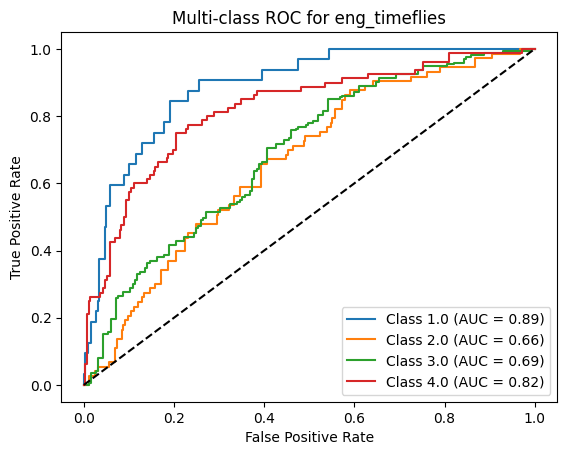

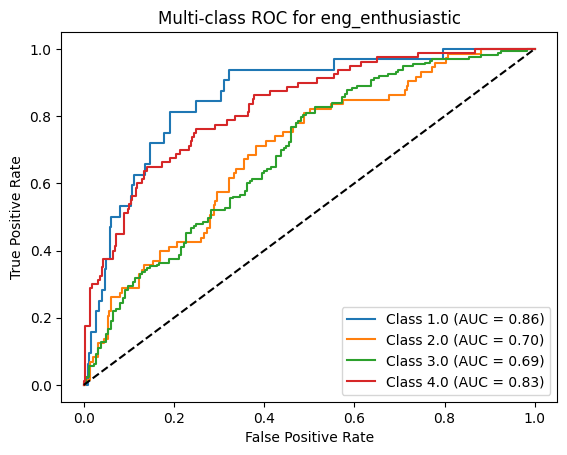

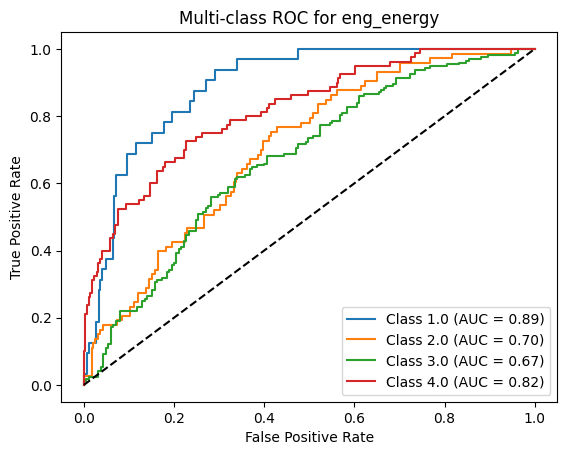

In [21]:
unique_classes = np.unique(Xgboost.y_test)

for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    probas = Results_XGB_Proba_dict[dimension][-1]

    # Binarize the output
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y_test, classes=np.unique(Xgboost.y_test))
    
    n_classes = y_bin.shape[1]

   # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure()
    for i, class_value in enumerate(unique_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_value} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC for {dimension}')
    plt.legend(loc="lower right")
    plt.show()